In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
# set plot style if no arguments provided
jtplot.style()

# Descriptive statistics

In this problem, we have a binary target variable, and a mix of input variables: numerical, categorical, and time sequences.

numerical: LIMIT_BAL, AGE, BILL_AMT, PAY_AMT and PAY.
categorical: SEX, EDUCATION and MARRIAGE.
time sequences:  BILL_AMT, PAY_AMT and PAY.

Here we should measure the association or correlation of our binary target with the mix of input variables, which is not available in pandas or pandas_profiling, and also there is not a visualization method as a scatter matrix like in continuous variables.

In [2]:
df = pd.read_excel("default of credit card clients.xls", header=1)
# put ID as DataFrame INDEX
df.set_index('ID', inplace=True)

In [3]:
# categorical and nominal: sex, education, marriage
# numerical variables: LIMIT_BAL, AGE
# count unique values for each variables
for i in df.columns:
    print(i, len(df[i].unique()))

LIMIT_BAL 81
SEX 2
EDUCATION 7
MARRIAGE 4
AGE 56
PAY_0 11
PAY_2 11
PAY_3 11
PAY_4 11
PAY_5 10
PAY_6 10
BILL_AMT1 22723
BILL_AMT2 22346
BILL_AMT3 22026
BILL_AMT4 21548
BILL_AMT5 21010
BILL_AMT6 20604
PAY_AMT1 7943
PAY_AMT2 7899
PAY_AMT3 7518
PAY_AMT4 6937
PAY_AMT5 6897
PAY_AMT6 6939
default payment next month 2


# Grouped histograms by default payment

<AxesSubplot:xlabel='AGE', ylabel='Probability'>

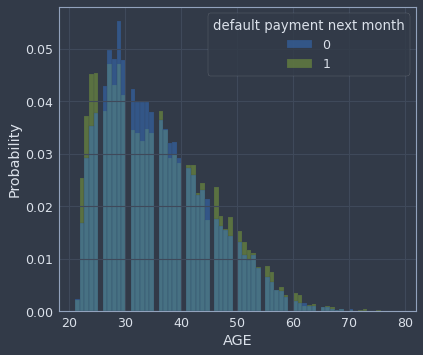

In [4]:
sns.histplot(data=df, x="AGE", hue="default payment next month",
             stat='probability', common_norm=False)

<AxesSubplot:xlabel='LIMIT_BAL', ylabel='Probability'>

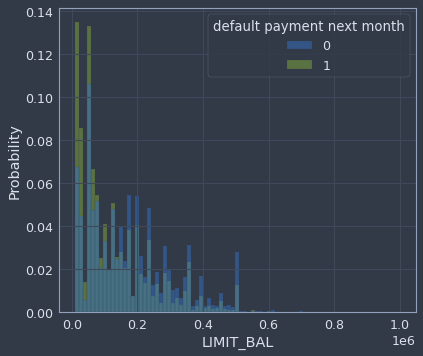

In [5]:
sns.histplot(data=df, x="LIMIT_BAL", hue="default payment next month",
             stat='probability', common_norm=False)

<AxesSubplot:xlabel='BILL_AMT1', ylabel='Probability'>

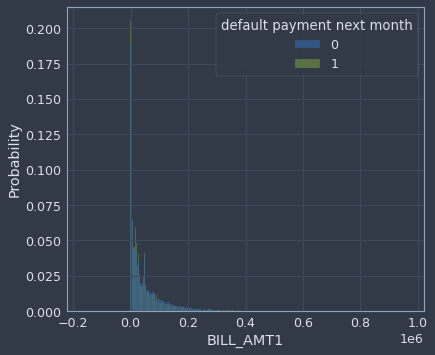

In [6]:
sns.histplot(data=df, x="BILL_AMT1", hue="default payment next month",
             stat='probability', common_norm=False)

In the histograms above, we can see two things: There is not an appreciable difference in the distributions due to the payment default category, and the distributions are right-skewed, which is a limitation for some machine learning algorithms. 

# Association analysis

## Association of categorical data

For the association of categorical data, I am going to use cramers_v correlation, which value has the range [0, 1], where 1 means absolute correlation.

IN the next code cell, we calculate the correlation of 'default payment' with marriage, sex and education.

In [7]:
import scipy.stats as ss

def cramers_v(x, y):
    """ This method calculates cramers correlation between two categorical variables.
    this method was taken from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
    Args:
        x (array): values of variable x
        y (array): valuesof variable y
    Returns:
        float: correlation in the range [0, 1]
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

print('MARRIAGE', cramers_v(df['MARRIAGE'], df['default payment next month']))
print('SEX', cramers_v(df['SEX'], df['default payment next month']))
print('EDUCATION', cramers_v(df['EDUCATION'], df['default payment next month']))

MARRIAGE 0.03299665874336609
SEX 0.03945897473696193
EDUCATION 0.07239281703731822


PAY sequence values are numerical but discrete, with 11 unique values. For these variables we can also use cramers_v to measure correlation with 'default payment'

In [8]:
for x in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
    print(x, cramers_v(df[x], df['default payment next month']))

PAY_0 0.4225376980470451
PAY_2 0.3398324070767322
PAY_3 0.29510161426216264
PAY_4 0.2787799211402479
PAY_5 0.27010908674532336
PAY_6 0.2501930992696595


PAY sequence has a much larger correlation with 'default payment' than EDUCATION, SEX and MARRIAGE. We can also see that the first lag('PAY_0') has the largest correlation of the sequence, and that the further in the pass the less the influence of PAY on 'default payment'.

## Association of continuous data

In this part, I am going to use Kruskal-Wallis H-test, which a non-parametric version of ANOVA, and does not assume a normal distribution.

This method does not give us a correlation coefficient, instead, it returns a p-value telling if the distributions for the continuous variable change because of the categories. Due to our binary target, this can be done also with Kolmogorov-Smirnov test.

In [9]:
from scipy import stats
columns = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

for x_var in columns:
    x = df[df['default payment next month']==1][x_var]
    y = df[df['default payment next month']==0][x_var]
    print(f"for {x_var}, the correlation is: {round(stats.kruskal(x, y).pvalue, 3)}")

for LIMIT_BAL, the correlation is: 0.0
for AGE, the correlation is: 0.373
for BILL_AMT1, the correlation is: 0.0
for BILL_AMT2, the correlation is: 0.007
for BILL_AMT3, the correlation is: 0.028
for BILL_AMT4, the correlation is: 0.148
for BILL_AMT5, the correlation is: 0.235
for BILL_AMT6, the correlation is: 0.989
for PAY_AMT1, the correlation is: 0.0
for PAY_AMT2, the correlation is: 0.0
for PAY_AMT3, the correlation is: 0.0
for PAY_AMT4, the correlation is: 0.0
for PAY_AMT5, the correlation is: 0.0
for PAY_AMT6, the correlation is: 0.0


I am going to use the classic threshold of  p-value<=0.05 for association with 'default payment'. So, we conclude that AGE has no influence, and also the lags from 4th lag in BILL_AMT. In contrast, we can see an strong influence for PAY_AMT(payment amount) variable sequence.

## Variable selection
From the exploration, the variables that can be eliminated, are: AGE, BILL_AMT4, BILL_AMT5, BILL_AMT6, MARRIAGE, SEX, EDUCATION. Feature importance can be also calculate using tree-based models.

## Model selection
Taken into account the characteristic of our dataset: categorical and continuous variables, skewed data, and continuous variables in different scales. The model that allows use this variables without any transformation(onehot encoding, MinMaxScale, etc), is RandomForestClassifier.

Before that, we should look for the imbalance of our target variable.

In [10]:
df['default payment next month'].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

`default payment` represents just the 22% of the data. This a problem for any ML model. In the case of RandomForestClassifier, this can be solved using `balanced` class weight while training.

Let us train with all the variables.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# train test split
X, y = df.drop('default payment next month', axis=1).values, df['default payment next month'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
clf = RandomForestClassifier(n_estimators=200, max_depth=15, bootstrap=True,
                             min_samples_leaf=5, class_weight='balanced_subsample',
                             max_samples=0.7, min_samples_split=10, max_features=0.7,
                             random_state=42, n_jobs=4)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features=0.7, max_samples=0.7, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=200, n_jobs=4,
                       random_state=42)

In [13]:
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     17491
           1       0.73      0.73      0.73      5009

    accuracy                           0.88     22500
   macro avg       0.83      0.83      0.83     22500
weighted avg       0.88      0.88      0.88     22500

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      5873
           1       0.54      0.49      0.51      1627

    accuracy                           0.80      7500
   macro avg       0.70      0.69      0.69      7500
weighted avg       0.79      0.80      0.80      7500



Lets try imblear package for imbalanced data.

In [14]:
from imblearn.ensemble import BalancedRandomForestClassifier
model = BalancedRandomForestClassifier(n_estimators=200, max_depth=15, bootstrap=True,
                                       min_samples_leaf=10, max_samples=0.7,
                                       min_samples_split=20, max_features=0.7,
                                       random_state=42, n_jobs=4, sampling_strategy=0.6)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred))
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     17491
           1       0.66      0.62      0.64      5009

    accuracy                           0.84     22500
   macro avg       0.78      0.76      0.77     22500
weighted avg       0.84      0.84      0.84     22500

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5873
           1       0.55      0.50      0.52      1627

    accuracy                           0.80      7500
   macro avg       0.71      0.69      0.70      7500
weighted avg       0.80      0.80      0.80      7500



After some hand-made hyperparameters tuning. We can see that both models have similar performance, with an accuracy of 0.8, which is 2 points above the imbalanced distribution of the data(0.78). The imblearn model is better in f1-score for the minority class than sklearn model.

Lets see the variable importance for each model.

In [15]:
pd.Series(clf.feature_importances_,
          index=df.drop('default payment next month', axis=1).columns).sort_values(ascending=False)

PAY_0        0.221132
PAY_2        0.070563
BILL_AMT1    0.057589
LIMIT_BAL    0.056147
PAY_AMT2     0.052563
PAY_AMT3     0.048749
AGE          0.048356
PAY_AMT4     0.046618
PAY_AMT1     0.044670
PAY_AMT6     0.043586
BILL_AMT2    0.042582
BILL_AMT6    0.038156
BILL_AMT3    0.037752
PAY_AMT5     0.036218
BILL_AMT5    0.034932
BILL_AMT4    0.034871
PAY_3        0.023016
PAY_4        0.017255
EDUCATION    0.012882
PAY_6        0.010730
SEX          0.007508
MARRIAGE     0.007188
PAY_5        0.006938
dtype: float64

In [16]:
pd.Series(model.feature_importances_,
          index=df.drop('default payment next month', axis=1).columns).sort_values(ascending=False)

PAY_0        0.294461
PAY_2        0.091554
LIMIT_BAL    0.050364
BILL_AMT1    0.050182
PAY_AMT2     0.043312
PAY_AMT3     0.042956
AGE          0.041166
PAY_AMT1     0.038830
PAY_AMT4     0.037645
PAY_AMT6     0.035733
BILL_AMT2    0.034862
PAY_AMT5     0.031647
BILL_AMT6    0.030387
BILL_AMT3    0.029688
BILL_AMT5    0.028592
PAY_3        0.028169
BILL_AMT4    0.027351
PAY_4        0.020287
PAY_6        0.010225
EDUCATION    0.009872
PAY_5        0.008597
MARRIAGE     0.007107
SEX          0.007014
dtype: float64

We can see that feature importance in both models is similar to the one in the early statistical analysis.
Drop the following variables:
[PAY_AMT5,BILL_AMT5,BILL_AMT4,    
PAY_3,PAY_4,EDUCATION,PAY_6,SEX,MARRIAGE,PAY_5]

In [17]:
drop = ['PAY_AMT5', 'BILL_AMT5','BILL_AMT4','PAY_3','PAY_4',
 'EDUCATION','PAY_6','SEX','MARRIAGE','PAY_5']
# train test split
X, y = df.drop(['default payment next month']+drop, axis=1).values, df['default payment next month'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
clf = RandomForestClassifier(n_estimators=200, max_depth=15, bootstrap=True,
                             min_samples_leaf=5, class_weight='balanced_subsample',
                             max_samples=0.7, min_samples_split=10, max_features=0.7,
                             random_state=42, n_jobs=4)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     17491
           1       0.71      0.73      0.72      5009

    accuracy                           0.87     22500
   macro avg       0.82      0.82      0.82     22500
weighted avg       0.88      0.87      0.88     22500

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      5873
           1       0.54      0.49      0.51      1627

    accuracy                           0.80      7500
   macro avg       0.70      0.69      0.69      7500
weighted avg       0.79      0.80      0.80      7500



In [19]:
model = BalancedRandomForestClassifier(n_estimators=200, max_depth=15, bootstrap=True,
                                       min_samples_leaf=10, max_samples=0.7,
                                       min_samples_split=20, max_features=0.7,
                                       random_state=42, n_jobs=4, sampling_strategy=0.6)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred))
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     17491
           1       0.66      0.61      0.63      5009

    accuracy                           0.84     22500
   macro avg       0.77      0.76      0.77     22500
weighted avg       0.84      0.84      0.84     22500

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      5873
           1       0.54      0.49      0.52      1627

    accuracy                           0.80      7500
   macro avg       0.70      0.69      0.70      7500
weighted avg       0.79      0.80      0.80      7500



Text(0.5, 1.0, '2-classes Precision-Recall curve: ')

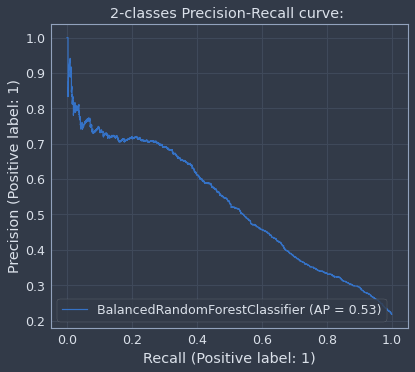

In [20]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

probas_pred = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(
    y_test, probas_pred)

disp = plot_precision_recall_curve(model, X_test, y_test)
disp.ax_.set_title('2-classes Precision-Recall curve: ')

There is not improvement after eliminating the least important features.

# Business perspective
The best model is able to detect 50% of clients that are going to be a `default payment`. The model has a false positive rate of 46%, but it is just 11% percent of good clients.

Now lest see the performance of the model not in terns of counting, but in terns of money(LIMIT_BAL). For that, I am going to use confusion matrix with sample weighted by LIMIT_BAL.

In [49]:
from sklearn.metrics import confusion_matrix
print("\n By rows(real values)")
print(confusion_matrix(y_test, y_pred,
                 sample_weight=(X_test[:, 0]), normalize='true'))
print("\n By columns(predicted values)")
print(confusion_matrix(y_test, y_pred,
                 sample_weight=(X_test[:, 0]), normalize='pred'))


 By rows(real values)
[[0.93058373 0.06941627]
 [0.60419896 0.39580104]]

 By columns(predicted values)
[[0.88317137 0.46259805]
 [0.11682863 0.53740195]]


Here we can see that the model is just able to detect 39% of default LIMIT_BAL, but is able to detect 93% of good LIMIT_BAL money. To improve this, we can use `class_weight` with LIMIT_BAL instead of frequency.